In [1]:
pwd

'/home/mohit19014/Hostility Detection/Code'

In [2]:
cd /home/mohit19014/Hostility Detection/Data

/home/mohit19014/Hostility Detection/Data


In [3]:
ls

 emoji2vec/                      pkl_combined_fine_train.pkl  'SPT Data'/
'Hindi Font'/                    pkl_fine_test.pkl             test.csv
 Hindi_Stopwords_Tokenized.pkl   pkl_fine_train.pkl            train.csv
'hindi stopwords.txt'            pkl_fine_valid.pkl            Untitled.ipynb
 IndicFT/                        Pretrained/                   valid.csv
'Old Pickles'/                   Random/


In [4]:
!nvidia-smi

Thu Apr  1 07:38:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:5E:00.0 Off |                    0 |
| N/A   47C    P0    51W / 250W |   2726MiB / 16160MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Installing Required Libraries

In [5]:
# pip install fasttext

In [6]:
# pip install gensim

In [7]:
# pip install transformers -q

In [8]:
# pip install sentencepiece -q

In [9]:
# !pip install emot -q

In [10]:
# !pip install emoji -q

<h4> Importing Libraries

In [11]:
### General
import re
import copy
import string
import pickle
import numpy as np
import pandas as pd
import fasttext
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings


import torch
import torch.nn as nn

### Transformers
from transformers import AutoTokenizer, AutoModel

### For Emojis and Hashtags
import emoji
from inltk.inltk import tokenize
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from ekphrasis.classes.segmenter import Segmenter


import gensim.models as gsm
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

#### Configuration


In [12]:
MAX_LENGTH = 128

tokenizer   = AutoTokenizer.from_pretrained('monsoon-nlp/hindi-bert')
bert_model  = AutoModel.from_pretrained('monsoon-nlp/hindi-bert', output_hidden_states = True, output_attentions = True)


In [ ]:
from inltk.inltk import setup
setup('hi')

In [14]:
ft_model = fasttext.load_model('IndicFT/indicnlp.ft.hi.300.bin')

In [15]:
seg_tw = Segmenter(corpus = "twitter")

Reading twitter - 1grams ...
Reading twitter - 2grams ...


<h2> Preprocessing

<h3> Fine Grained Constraint Dataset

In [15]:
train = pd.read_csv('SPT Data/train.csv')
valid = pd.read_csv('SPT Data/valid.csv')
test = pd.read_csv('SPT Data/test.csv')

print(train.shape)
print(test.shape)
print(test.shape)

train.head(2)

(5728, 3)
(1653, 3)
(1653, 3)


,Unique ID,Post,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,non-hostile


In [16]:
def create_hostile_columns(df):
    
    df = df.dropna()
    
    df.insert(len(df.columns)-1,'Hostile', np.zeros(len(df),dtype=int))
    df.insert(len(df.columns)-1,'Defamation', np.zeros(len(df),dtype=int))
    df.insert(len(df.columns)-1,'Fake', np.zeros(len(df),dtype=int))
    df.insert(len(df.columns)-1,'Hate', np.zeros(len(df),dtype=int))
    df.insert(len(df.columns)-1,'Offensive', np.zeros(len(df),dtype=int))


    for i in range(len(df)):
        text = df['Labels Set'][i]
        text = text.lower()
        text = text.replace('\n',"")
        text = text.replace('"',"")
        text = text.replace(" ","")
        text = text.split(',')

        for word in text:
            if word == 'defamation':
                df.at[i,'Hostile']    = 1
                df.at[i,'Defamation'] = 1

            if word == 'fake':
                df.at[i,'Hostile']    = 1
                df.at[i,'Fake'] = 1

            if word == 'hate':
                df.at[i,'Hostile']    = 1
                df.at[i,'Hate'] = 1

            if word == 'offensive':
                df.at[i,'Hostile']    = 1
                df.at[i,'Offensive'] = 1

    return df 

In [17]:
train = create_hostile_columns(train)
valid = create_hostile_columns(valid)
test  = create_hostile_columns(test)


print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 8)
(811, 8)
(1653, 8)


,Unique ID,Post,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,0,0,0,0,0,non-hostile


In [18]:
pickle.dump(train,open("pkl_fine_train.pkl",'wb'))
pickle.dump(valid,open("pkl_fine_valid.pkl",'wb'))
pickle.dump(test,open("pkl_fine_test.pkl",'wb'))

In [19]:
train =  pickle.load(open("pkl_fine_train.pkl",'rb'))
valid =  pickle.load(open("pkl_fine_valid.pkl",'rb'))
test  =  pickle.load(open("pkl_fine_test.pkl",'rb'))

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 8)
(811, 8)
(1653, 8)


,Unique ID,Post,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,0,0,0,0,0,non-hostile


<h3> Text Preprocessing

In [60]:
train =  pickle.load(open("pkl_fine_train.pkl",'rb'))
valid =  pickle.load(open("pkl_fine_valid.pkl",'rb'))
test  =  pickle.load(open("pkl_fine_test.pkl",'rb'))

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 8)
(811, 8)
(1653, 8)


,Unique ID,Post,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,0,0,0,0,0,non-hostile


In [65]:
### Preprocessing Flag = 0 --> Raw Text 
###               Flag = 1 --> Without Emojis
###               Flag = 2 --> With Emoji

def add_raw_text(df,flag):
    
    
    column_index = [2,3,4]
    column_names = ["Raw Text", "Raw Text without Emoji", "Raw Text with Emoji"]
    
    df.insert(column_index[flag], column_names[flag], ""*len(df))
    for i in range(len(df)):
        text = df['Post'][i]
        
        if(flag==1):
            ## Removing Emojis
            emojis = re.compile("["      u"\U0001F600-\U0001F64F"  # emoticons
                                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                        u"\U00002500-\U00002BEF"  # chinese char
                                        u"\U00002702-\U000027B0"
                                        u"\U00002702-\U000027B0"
                                        u"\U000024C2-\U0001F251"
                                        u"\U0001f926-\U0001f937"
                                        u"\U00010000-\U0010ffff"
                                        u"\u2640-\u2642"
                                        u"\u2600-\u2B55"
                                        u"\u200d"
                                        u"\u23cf"
                                        u"\u23e9"
                                        u"\u231a"
                                        u"\ufe0f"  # dingbats
                                        u"\u3030"
                                        "]+", flags=re.UNICODE)
            text =  emojis.sub(r'', text)
            
        if(flag==2):
            text = emoji.demojize(text, delimiters=("" , " "))
            
        df.at[i,column_names[flag]] = text
        
    return df

In [64]:
# a = copy.deepcopy(train)
# a = add_raw_text(a,2)

मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 

folded_hands  जय श्री राम folded_hands 


In [66]:
train = add_raw_text(train,0)
valid = add_raw_text(valid,0)
test  = add_raw_text(test,0)

train = add_raw_text(train,1)
valid = add_raw_text(valid,1)
test  = add_raw_text(test,1)

train = add_raw_text(train,2)
valid = add_raw_text(valid,2)
test  = add_raw_text(test,2)

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 11)
(811, 11)
(1653, 11)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,0,0,0,0,0,non-hostile


In [67]:
print(train['Post'][0])
print(train['Raw Text'][0])
print(train['Raw Text with Emoji'][0])
print(train['Raw Text without Emoji'][0])

मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 

🙏 जय श्री राम 🙏
मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 

🙏 जय श्री राम 🙏
मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 

folded_hands  जय श्री राम folded_hands 
मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 

 जय श्री राम 


In [68]:
print(train['Post'][2],"\n\n")
print(train['Raw Text without Emoji'][2])

सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE :  https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM 


सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE :  https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM


In [69]:
pickle.dump(train,open("pkl_fine_train.pkl",'wb'))
pickle.dump(valid,open("pkl_fine_valid.pkl",'wb'))
pickle.dump(test,open("pkl_fine_test.pkl",'wb'))

In [70]:
train = pickle.load(open("pkl_fine_train.pkl",'rb'))
valid = pickle.load(open("pkl_fine_valid.pkl",'rb'))
test = pickle.load(open("pkl_fine_test.pkl",'rb'))

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 11)
(811, 11)
(1653, 11)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,0,0,0,0,0,non-hostile


<h4> Hindi Stopwords

In [71]:
hi_stopwords = open("hindi stopwords.txt").read()
hi_stopwords = hi_stopwords.split("\n")

print(len(hi_stopwords))
print(hi_stopwords[:10])

412
['मैं', 'मुझको', 'मेरा', 'अपने आप को', 'हमने', 'हमारा', 'अपना', 'हम', 'आप', 'आपका']


In [77]:
### Preprocessing Flag = 0 --> Raw Text 
###               Flag = 1 --> Without Emojis
###               Flag = 2 --> With Emoji

def preprocess(df,flag):

    column_index = [5,6,7]
    column_names = ["Preprocessed", "Preprocessed without Emoji", "Preprocessed with Emoji"]
    
    df.insert(column_index[flag], column_names[flag], ""*len(df))
    
    for i in range(len(df)):
        text = df['Post'][i]

        ### Converting Every URL to https://someurl
        text = re.sub('htt[p^ps][a-zA-Z0-9./:]*', '',text)

        ### Converting Every User Mention to @Someuser
        text = re.sub('@[a-zA-Z0-9_]*', '', text)

        ### Segmenting Hashtags using Twitter Hashtag Segmenter
        text = ' '.join([seg_tw.segment(word[1:]) if word[0] == '#' else word for word in text.split()])
           
        text = text.lower()


        if(flag==1):
            ## Removing Emojis
            emojis = re.compile("["     u"\U0001F600-\U0001F64F"  # emoticons
                                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                        u"\U00002500-\U00002BEF"  # chinese char
                                        u"\U00002702-\U000027B0"
                                        u"\U00002702-\U000027B0"
                                        u"\U000024C2-\U0001F251"
                                        u"\U0001f926-\U0001f937"
                                        u"\U00010000-\U0010ffff"
                                        u"\u2640-\u2642"
                                        u"\u2600-\u2B55"
                                        u"\u200d"
                                        u"\u23cf"
                                        u"\u23e9"
                                        u"\u231a"
                                        u"\ufe0f"  # dingbats
                                        u"\u3030"
                                        "]+", flags=re.UNICODE)
            text =  emojis.sub(r'', text)
            
        if(flag==2):
            text = emoji.demojize(text, delimiters=("" , " "))
        

        ### Removing Punctuations
        table = str.maketrans("","", string.punctuation)
        text = text.translate(table)
        
        ### Removing Stopwords
        text = ' '.join(['' if word in hi_stopwords else word for word in text.split()])
        df.at[i,column_names[flag]] = text
    return df

In [76]:
# a = copy.deepcopy(train)
# a = preprocess(a,0)

मेरे देश के हिन्दु  निराले है।   पक्के राम भक्त    बाबर के साले  🙏 जय श्री राम 🙏


In [78]:
train = preprocess(train,0)
valid = preprocess(valid,0)
test  = preprocess(test,0)

train = preprocess(train,1)
valid = preprocess(valid,1)
test  = preprocess(test,1)

train = preprocess(train,2)
valid = preprocess(valid,2)
test  = preprocess(test,2)

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 14)
(811, 14)
(1653, 14)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,0,0,0,0,0,non-hostile


In [79]:
train.columns

Index(['Unique ID', 'Post', 'Raw Text', 'Raw Text without Emoji',
       'Raw Text with Emoji', 'Preprocessed', 'Preprocessed without Emoji',
       'Preprocessed with Emoji', 'Hostile', 'Defamation', 'Fake', 'Hate',
       'Offensive', 'Labels Set'],
      dtype='object')

In [80]:
print(train['Post'][0])
print(train['Preprocessed with Emoji'][0])
print(train['Preprocessed without Emoji'][0])

मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 

🙏 जय श्री राम 🙏
मेरे देश के हिन्दु  निराले है।   पक्के राम भक्त    बाबर के साले  foldedhands जय श्री राम foldedhands
मेरे देश के हिन्दु  निराले है।   पक्के राम भक्त    बाबर के साले  जय श्री राम


In [81]:
print(train['Post'][2],"\n\n")
print(train['Preprocessed without Emoji'][2])

सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE :  https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM 


सुशांत   बिजनेस डील 9 जून    वो डील दीपेश  सुशांत  हत्या के दिन   याद आई देखिए पूछता  भारत अर्नब के  रिपब्लिक भारत  live


In [82]:
pickle.dump(train,open("pkl_fine_train.pkl",'wb'))
pickle.dump(valid,open("pkl_fine_valid.pkl",'wb'))
pickle.dump(test,open("pkl_fine_test.pkl",'wb'))

In [83]:
train = pickle.load(open("pkl_fine_train.pkl",'rb'))
valid = pickle.load(open("pkl_fine_valid.pkl",'rb'))
test = pickle.load(open("pkl_fine_test.pkl",'rb'))

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 14)
(811, 14)
(1653, 14)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,0,0,0,0,0,non-hostile


<h3> Using Sentence Piece Tokenizer

In [108]:
train = pickle.load(open("pkl_fine_train.pkl",'rb'))
valid = pickle.load(open("pkl_fine_valid.pkl",'rb'))
test = pickle.load(open("pkl_fine_test.pkl",'rb'))

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 14)
(811, 14)
(1653, 14)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,0,0,0,0,0,non-hostile


In [109]:
def sent_piece_tokenize(df, flag):

    column_index = [8,9,10,11,12,13]
    column_names = ["Sentence Piece Raw Text", "Sentence Piece Raw Text without Emoji", "Sentence Piece Raw Text with Emoji",
                    "Sentence Piece Preprocessed", "Sentence Piece Preprocessed without Emoji", "Sentence Piece Preprocessed with Emoji"]
    org_col_name = ["Raw Text", "Raw Text without Emoji", "Raw Text with Emoji",
                    "Preprocessed", "Preprocessed without Emoji", "Preprocessed with Emoji"]
    
    
    df.insert(column_index[flag], column_names[flag], ""*len(df))
    for i in range(len(df)):
        text = df[org_col_name[flag]][i]
        tokenized = tokenizer.encode_plus(text, 
                                          max_length = MAX_LENGTH,
                                          #padding    = 'max_length',
                                          truncation = True,
                                          return_attention_mask = True,
                                          return_token_type_ids = False,
                                          return_tensors        = 'pt')
        
        input_ids = tokenized['input_ids']
        text = tokenizer.convert_ids_to_tokens(input_ids[0])
        text = ' '.join(text)
        df.at[i,column_names[flag]] = text
    return df

In [100]:
# a = copy.deepcopy(train)
# a = sent_piece_tokenize(a,5)

[CLS] मेरे देश के हिन्दु निरा ##ले है । पक्के राम भक्त बाबर के साले f ##old ##ed ##han ##d ##s जय श्री राम f ##old ##ed ##han ##d ##s [SEP]


In [110]:

for i in range(0,6):
    train = sent_piece_tokenize(train,i)
    valid = sent_piece_tokenize(valid,i)
    test  = sent_piece_tokenize(test,i)


print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 20)
(811, 20)
(1653, 20)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,Sentence Piece Raw Text with Emoji,Sentence Piece Preprocessed,Sentence Piece Preprocessed without Emoji,Sentence Piece Preprocessed with Emoji,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु निरा ##ले है । पक्के ...,[CLS] मेरे देश के हिन्दु निरा ##ले है । पक्के ...,[CLS] मेरे देश के हिन्दु निरा ##ले है । पक्के ...,1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा किसानों कमाई बढ़ाने के नई ##...,[CLS] सरकार हमेशा किसानों कमाई बढ़ाने के नई ##...,[CLS] सरकार हमेशा किसानों कमाई बढ़ाने के नई ##...,0,0,0,0,0,non-hostile


In [111]:
for column in train.columns:
    print(column)

Unique ID
Post
Raw Text
Raw Text without Emoji
Raw Text with Emoji
Preprocessed
Preprocessed without Emoji
Preprocessed with Emoji
Sentence Piece Raw Text
Sentence Piece Raw Text without Emoji
Sentence Piece Raw Text with Emoji
Sentence Piece Preprocessed
Sentence Piece Preprocessed without Emoji
Sentence Piece Preprocessed with Emoji
Hostile
Defamation
Fake
Hate
Offensive
Labels Set


In [112]:
print(train['Sentence Piece Raw Text'][0])
print(train['Sentence Piece Raw Text with Emoji'][0])
print(train['Sentence Piece Raw Text without Emoji'][0])

print("\n\n")

print(train['Sentence Piece Preprocessed'][0])
print(train['Sentence Piece Preprocessed with Emoji'][0])
print(train['Sentence Piece Preprocessed without Emoji'][0])

[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏 [SEP]
[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है f ##old ##ed _ h ##ands जय श्री राम f ##old ##ed _ h ##ands [SEP]
[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है जय श्री राम [SEP]



[CLS] मेरे देश के हिन्दु निरा ##ले है । पक्के राम भक्त बाबर के साले 🙏 जय श्री राम 🙏 [SEP]
[CLS] मेरे देश के हिन्दु निरा ##ले है । पक्के राम भक्त बाबर के साले f ##old ##ed ##han ##d ##s जय श्री राम f ##old ##ed ##han ##d ##s [SEP]
[CLS] मेरे देश के हिन्दु निरा ##ले है । पक्के राम भक्त बाबर के साले जय श्री राम [SEP]


In [113]:
pickle.dump(train,open("pkl_fine_train.pkl",'wb'))
pickle.dump(valid,open("pkl_fine_valid.pkl",'wb'))
pickle.dump(test,open("pkl_fine_test.pkl",'wb'))

<h3> Creating Counts Dictionary  

In [184]:
train =  pickle.load(open("pkl_fine_train.pkl",'rb'))
valid =  pickle.load(open("pkl_fine_valid.pkl",'rb'))
test  =  pickle.load(open("pkl_fine_test.pkl",'rb'))

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 20)
(811, 20)
(1653, 20)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,Sentence Piece Raw Text with Emoji,Sentence Piece Preprocessed,Sentence Piece Preprocessed without Emoji,Sentence Piece Preprocessed with Emoji,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु निरा ##ले है । पक्के ...,[CLS] मेरे देश के हिन्दु निरा ##ले है । पक्के ...,[CLS] मेरे देश के हिन्दु निरा ##ले है । पक्के ...,1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा किसानों कमाई बढ़ाने के नई ##...,[CLS] सरकार हमेशा किसानों कमाई बढ़ाने के नई ##...,[CLS] सरकार हमेशा किसानों कमाई बढ़ाने के नई ##...,0,0,0,0,0,non-hostile


In [185]:
### Using only Train and Validation Data Samples
def create_counts_dict(df,flag):
    
    dict = {}
    org_col_name = ["Sentence Piece Raw Text", "Sentence Piece Raw Text without Emoji", "Sentence Piece Raw Text with Emoji",
                    "Sentence Piece Preprocessed", "Sentence Piece Preprocessed without Emoji", "Sentence Piece Preprocessed with Emoji"]
 
    
    print("------- Creating ", org_col_name[flag], " Lex Count Dict--------\n\n")
    for i in range(len(df)):
        text = df[org_col_name[flag]][i]
        for word in text.split():
            if dict.get(word) == None:
                dict[word] = [0,0,0,0,0] ### indexing like - [#def, #fake, #hate, #offensive, #non_hostile]

            if(df['Hostile'][i]==0):
                dict[word][4] += 1
                continue

            if(df['Defamation'][i]==1):
                dict[word][0] += 1

            if(df['Fake'][i]==1):
                dict[word][1] += 1

            if(df['Hate'][i]==1):
                dict[word][2] += 1

            if(df['Offensive'][i]==1):
                dict[word][3] += 1
    
    print("\n\n----------Stats----------\n\n")
    print(len(dict))
    for i,key in enumerate(dict.keys()):
        print(key,dict[key])
        if(i>21):
            break
            
    print("\n\n----------Deleting CLS, SEP, and Puncs----------\n\n")
    
    deleted_keys = 0
    stopwords = ["[CLS]", "[SEP]", '"' , "'", ":" , ";", ",", ".", "|"]

    for i,key in enumerate(dict.keys()):
          if key in stopwords:
            dict[key]     = [0,0,0,0,0]
            deleted_keys += 1


    print("Number of keys :          ",len(dict))
    print("Number of keys Nullified: ",deleted_keys)
    
    print(dict["[CLS]"])
    print(dict["महिला"])
    
    print("\n\n-------Dumping Lex Count Dictionary----------\n\n")
    pickle.dump(dict, open(org_col_name[flag]+".pkl",'wb'))

In [186]:
combined_df = pd.concat([train,valid],axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df.shape

(6539, 20)

In [187]:
# for i in range(0,6):
#     create_counts_dict(combined_df,i)

------- Creating  Sentence Piece Raw Text  Lex Count Dict--------




----------Stats----------


15759
[CLS] [641, 1304, 902, 845, 3485]
मेरे [17, 24, 24, 16, 20]
देश [104, 152, 204, 118, 235]
के [566, 1557, 879, 654, 3481]
हिन्दु [1, 14, 11, 5, 0]
बहुत [33, 50, 44, 35, 59]
निरा [0, 0, 1, 1, 0]
##ले [4, 9, 7, 9, 5]
है [784, 1505, 1151, 1057, 1551]
। [337, 1349, 587, 482, 1633]
कुछ [50, 97, 79, 65, 68]
तो [225, 253, 332, 301, 154]
पक्के [0, 0, 1, 1, 1]
राम [30, 54, 45, 38, 41]
भक्त [17, 12, 10, 9, 5]
और [203, 616, 375, 280, 875]
बाबर [2, 2, 1, 2, 0]
साले [20, 4, 66, 85, 0]
🙏 [13, 6, 9, 14, 2]
जय [11, 78, 31, 29, 28]
श्री [9, 38, 20, 16, 265]
[SEP] [641, 1304, 902, 845, 3485]
सरकार [53, 119, 87, 41, 215]


----------Deleting CLS, SEP, and Puncs----------


Number of keys :           15759
Number of keys Nullified:  9
[0, 0, 0, 0, 0]
[6, 54, 11, 11, 62]


-------Dumping Lex Count Dictionary----------


------- Creating  Sentence Piece Raw Text without Emoji  Lex Count Dict--------




--

In [188]:
lex_count = pickle.load(open("Sentence Piece Raw Text.pkl",'rb')) 

In [189]:
print(len(lex_count))
for i,key in enumerate(lex_count.keys()):
    print(key,lex_count[key])
    if(i>2):
        break

15759
[CLS] [0, 0, 0, 0, 0]
मेरे [17, 24, 24, 16, 20]
देश [104, 152, 204, 118, 235]
के [566, 1557, 879, 654, 3481]


In [190]:
lex_count['महिला']

[6, 54, 11, 11, 62]

In [191]:
lex_count['मुसलमान']

[7, 24, 27, 18, 2]

<h4> TSNE Plot

In [201]:
from sklearn.manifold import TSNE
def plot_tsne(hostility_dict):

    SMALL_SIZE = 15
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 25

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    tsne = TSNE(n_components=2, random_state=0)

    embeddings = []
    labels     = []
    for key in hostility_dict.keys():
        values = hostility_dict[key]
        
        embeddings.append(values)
        labels.append(values.index(max(values)))

    embeddings = np.asarray(embeddings)
    labels     = np.asarray(labels)

    cname_dict = {0: 'Defamation', 1:'Fake', 2: 'Hate', 3: 'Offensive', 4: 'Non-Hostile'}

    transformed = tsne.fit_transform(embeddings)
    fig, ax = plt.subplots(figsize=(20,20))
    for label in np.unique(labels): 
        indices = [i for i, l in enumerate(labels) if l == label]
        x = np.take(transformed[:,0], indices)
        y = np.take(transformed[:,1], indices)

        cdict = {0: 'red', 1: 'blue', 2: 'orange', 3: 'violet', 4: 'green'}
        ax.scatter(x,y, color = cdict[label], label=cname_dict[label])
    
    ax.legend(loc='best')
    plt.show()

In [202]:
def create_softmax_hostility_dict(df, flag):

    hostility_dict = {}
    total_samples = [0,0,0,0,0] ### total samples in Defamation, fake, hate, offensive, non-hostile

    total_samples[0] = df['Defamation'].value_counts()[1]
    total_samples[1] = df['Fake'].value_counts()[1]
    total_samples[2] = df['Hate'].value_counts()[1]
    total_samples[3] = df['Offensive'].value_counts()[1]
    total_samples[4] = df['Hostile'].value_counts()[0]


    print(total_samples)
    
    org_col_name = ["Sentence Piece Raw Text", "Sentence Piece Raw Text without Emoji", "Sentence Piece Raw Text with Emoji",
                    "Sentence Piece Preprocessed", "Sentence Piece Preprocessed without Emoji", "Sentence Piece Preprocessed with Emoji"]
 
    new_col_name = ["Hostility Dict Raw Text", "Hostility Dict Raw Text without Emoji", "Hostility Dict Raw Text with Emoji",
                    "Hostility Dict Preprocessed", "Hostility Dict Preprocessed without Emoji", "Hostility Dict Preprocessed with Emoji"]
 

    print("\n\n----------Creating ", new_col_name[flag], " Hostility Dict----------\n\n")      
    lexicon_count = pickle.load(open(org_col_name[flag]+".pkl", 'rb'))
    
    for key in lexicon_count.keys():
        values = lexicon_count[key]

        ### Normalizing across word wise
        total = sum(values)
        if(total!=0):
            values = [value/total for value in values]
        
            ### Normalizing across column wise
            values = [500*(a/b) for a,b in zip(values,total_samples)]



            non_def_total  = values[1] + values[2] + values[3] #+ values[4]
            non_fake_total = values[0] + values[2] + values[3] #+ values[4]
            non_hate_total = values[0] + values[1] + values[3] #+ values[4]
            non_off_total  = values[0] + values[1] + values[2] #+ values[4]
            hostile_total  = values[0] + values[1] + values[2] + values[3]

            hostility_dict[key] = [values[0] - non_def_total,
                                   values[1] - non_fake_total,
                                   values[2] - non_hate_total,
                                   values[3] - non_off_total,
                                   values[4] - hostile_total]



#             print(hostility_dict[key])
            hostility_dict[key] = [100*i for i in hostility_dict[key]]
            hostility_dict[key] = torch.softmax(torch.tensor(hostility_dict[key]),dim=0)
            hostility_dict[key] = [float(i) for i in hostility_dict[key]]
#             print(hostility_dict[key])
        
        else:
            hostility_dict[key] = [0.0, 0.0, 0.0, 0.0 ,0.0]
    

    print("\n\n----------Stats-----------\n\n")
    print(len(hostility_dict))
    for i,key in enumerate(hostility_dict.keys()):
        print(key,hostility_dict[key])
        if(i>3):
            break
            
    print("\n\n---------Mapping of a word to a dimension----------\n\n")
    
    mapping_dict = { 0: 'Defamation',
                     1: 'Fake',
                     2: 'Hate',
                     3: 'Offensive'}

    print("Word महिला mapped to index : ", mapping_dict[hostility_dict['महिला'].index(max(hostility_dict['महिला']))])
    print("Word भक्त mapped to index : ", mapping_dict[hostility_dict['भक्त'].index(max(hostility_dict['भक्त']))])
    print("Word देश mapped to index : ", mapping_dict[hostility_dict['देश'].index(max(hostility_dict['देश']))])
    print("Word हिन्दु mapped to index : ", mapping_dict[hostility_dict['हिन्दु'].index(max(hostility_dict['हिन्दु']))])
    print("Word मुसलमान mapped to index : ", mapping_dict[hostility_dict['मुसलमान'].index(max(hostility_dict['मुसलमान']))])


    
    
    print("\n\n--------------TSNE Plot of ",org_col_name[flag], " Hostility Dict--------------\n\n")
    plot_tsne(hostility_dict)   
    
    print("\n\n--------------Dumping Hostility Dict-------------\n\n")
    pickle.dump(hostility_dict, open(new_col_name[flag]+".pkl",'wb'))

    return hostility_dict

In [203]:
combined_df = pd.concat([train,valid],axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df.shape

(6539, 20)

[641, 1304, 902, 845, 3485]


----------Creating  Hostility Dict Raw Text  Hostility Dict----------




----------Stats-----------


15759
[CLS] [0.0, 0.0, 0.0, 0.0, 0.0]
मेरे [0.4784082724414969, 0.0001548450370049452, 0.5211751872635509, 0.0002616952256078803, 3.233933875384392e-11]
देश [0.0003849671640353424, 1.3968321365046493e-06, 0.9995897535140459, 2.3882437364364898e-05, 5.24180541597819e-11]
के [0.012060006430132853, 0.9417985432881055, 0.04346809047976432, 0.0026174760260486846, 5.588377594861737e-05]
हिन्दु [1.2499884855072601e-15, 0.008957984097284892, 0.9910420143142354, 1.588478370839866e-09, 8.153361170313532e-18]


---------Mapping of a word to a dimension----------


Word महिला mapped to index :  Fake
Word भक्त mapped to index :  Defamation
Word देश mapped to index :  Hate
Word हिन्दु mapped to index :  Hate
Word मुसलमान mapped to index :  Hate


--------------TSNE Plot of  Sentence Piece Raw Text  Hostility Dict--------------




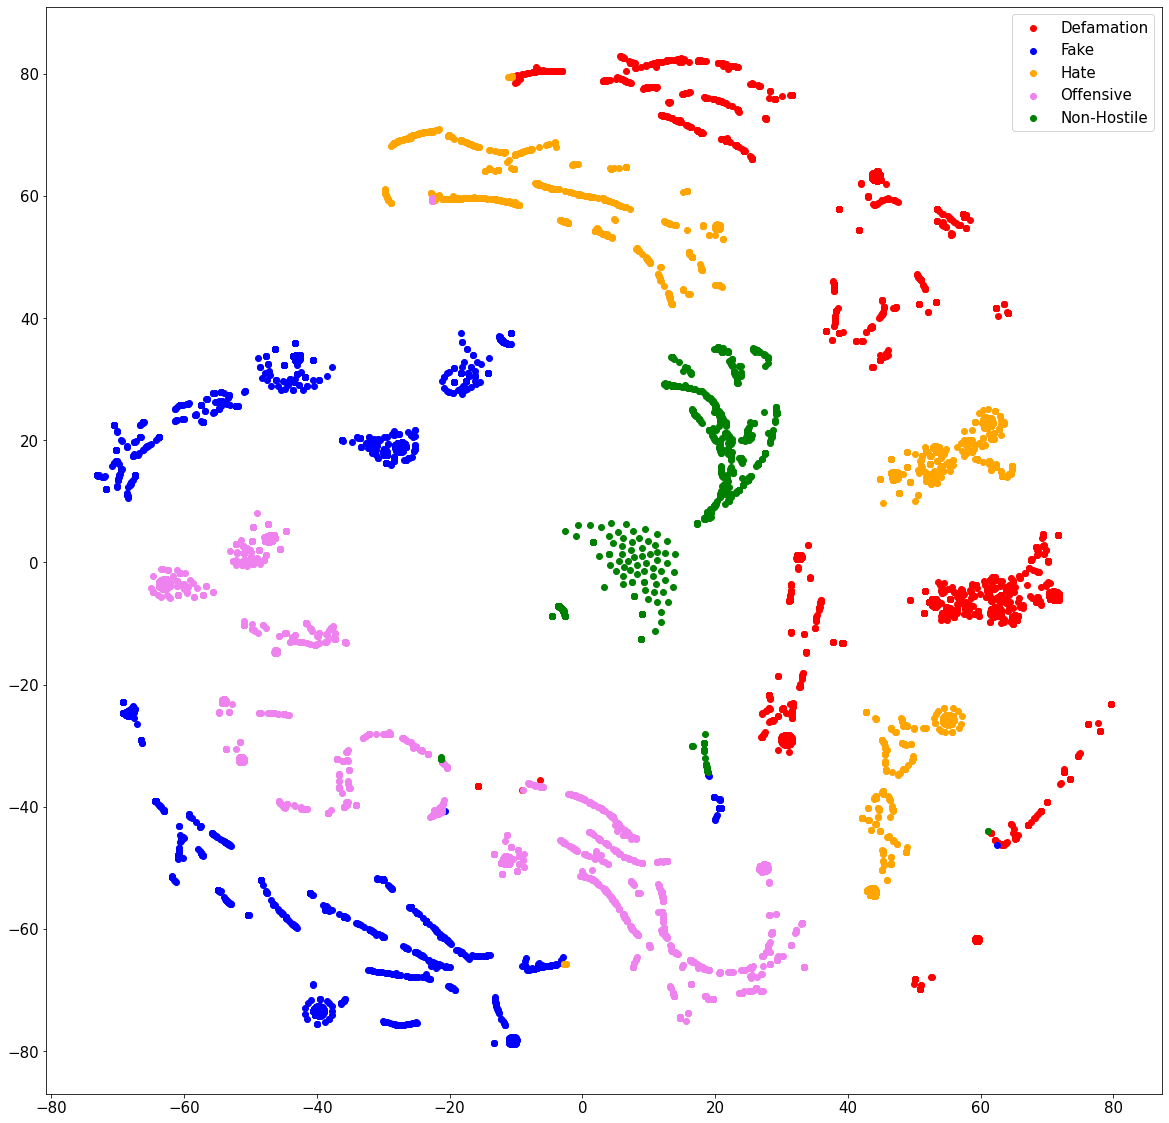



--------------Dumping Hostility Dict-------------


[641, 1304, 902, 845, 3485]


----------Creating  Hostility Dict Raw Text without Emoji  Hostility Dict----------




----------Stats-----------


15740
[CLS] [0.0, 0.0, 0.0, 0.0, 0.0]
मेरे [0.4784082724414969, 0.0001548450370049452, 0.5211751872635509, 0.0002616952256078803, 3.233933875384392e-11]
देश [0.0003962502880852123, 1.4677826071092519e-06, 0.9995735708671059, 2.8711002972028917e-05, 5.922991035961846e-11]
के [0.012329126069741745, 0.9408536095692523, 0.04414211933625781, 0.0026191648961894527, 5.5980128558685584e-05]
हिन्दु [1.2499884855072601e-15, 0.008957984097284892, 0.9910420143142354, 1.588478370839866e-09, 8.153361170313532e-18]


---------Mapping of a word to a dimension----------


Word महिला mapped to index :  Fake
Word भक्त mapped to index :  Defamation
Word देश mapped to index :  Hate
Word हिन्दु mapped to index :  Hate
Word मुसलमान mapped to index :  Hate


--------------TSNE Plot of  Sentence Piece Raw Text wi

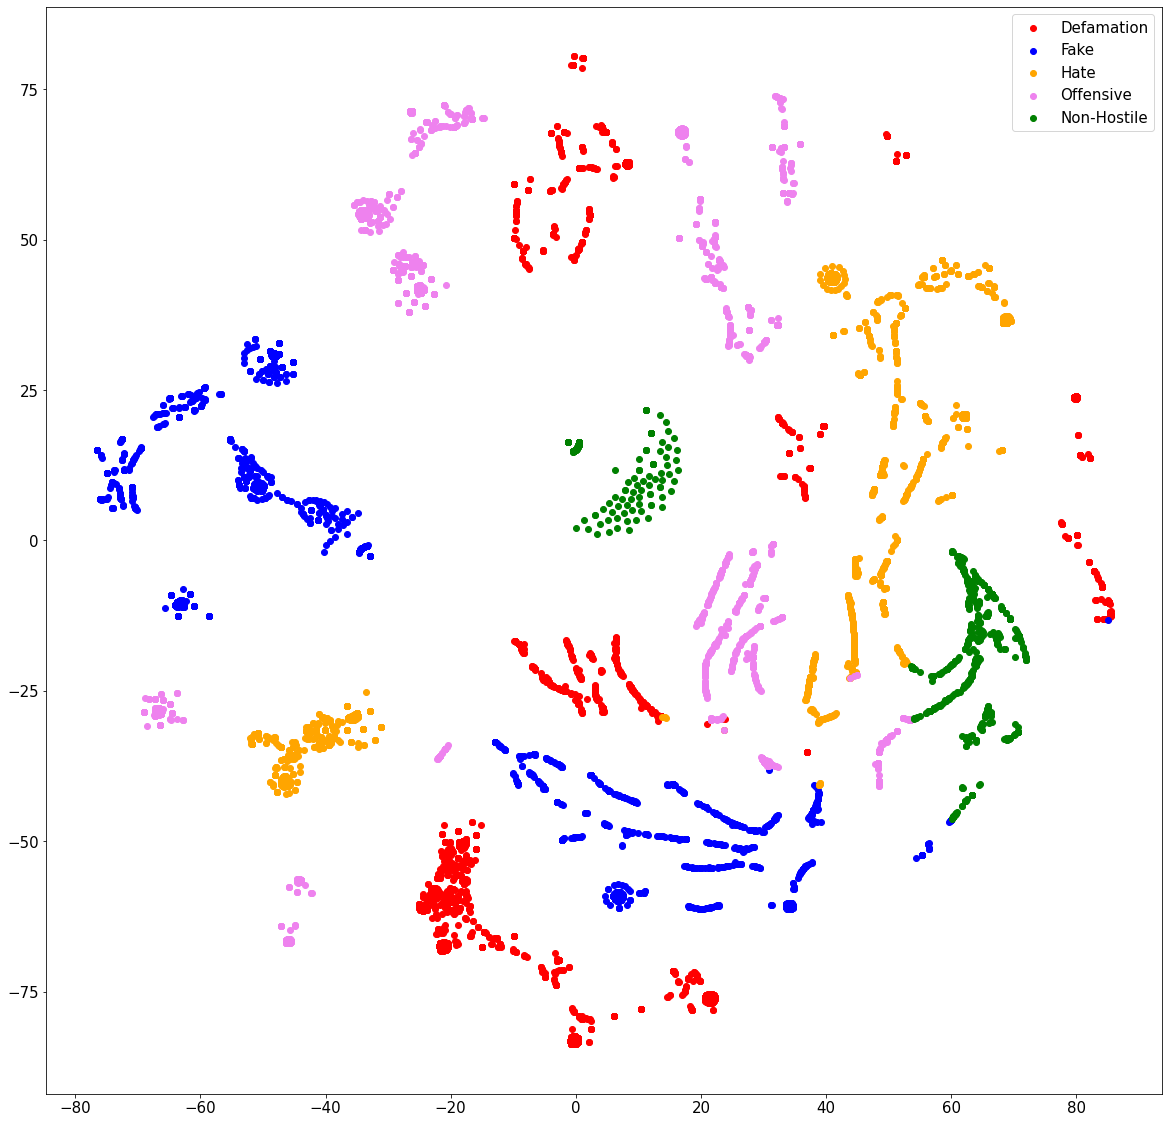



--------------Dumping Hostility Dict-------------


[641, 1304, 902, 845, 3485]


----------Creating  Hostility Dict Raw Text with Emoji  Hostility Dict----------




----------Stats-----------


15784
[CLS] [0.0, 0.0, 0.0, 0.0, 0.0]
मेरे [0.4784082724414969, 0.0001548450370049452, 0.5211751872635509, 0.0002616952256078803, 3.233933875384392e-11]
देश [0.000441182708110596, 1.3255875182007838e-06, 0.9995258331005824, 3.1658541558150525e-05, 6.223058498660715e-11]
के [0.01279422668243918, 0.9386656103221424, 0.045856495841836376, 0.0026258382597782906, 5.7828893803626255e-05]
हिन्दु [1.2499884855072601e-15, 0.008957984097284892, 0.9910420143142354, 1.588478370839866e-09, 8.153361170313532e-18]


---------Mapping of a word to a dimension----------


Word महिला mapped to index :  Fake
Word भक्त mapped to index :  Defamation
Word देश mapped to index :  Hate
Word हिन्दु mapped to index :  Hate
Word मुसलमान mapped to index :  Hate


--------------TSNE Plot of  Sentence Piece Raw Text with E

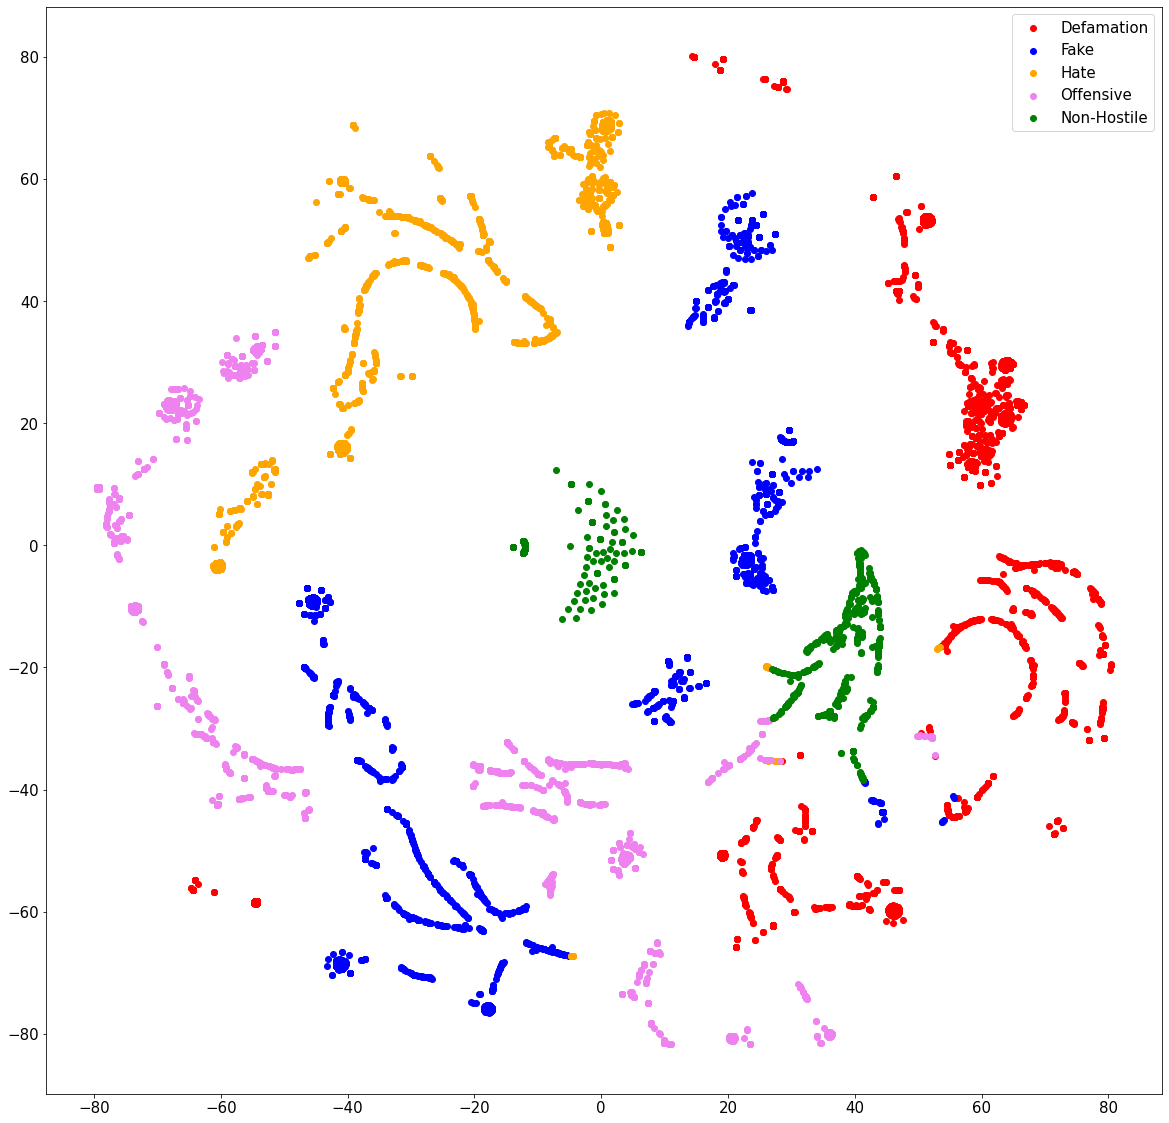



--------------Dumping Hostility Dict-------------


[641, 1304, 902, 845, 3485]


----------Creating  Hostility Dict Preprocessed  Hostility Dict----------




----------Stats-----------


15302
[CLS] [0.0, 0.0, 0.0, 0.0, 0.0]
मेरे [0.478213942975029, 0.0017828147452921103, 0.5196783677416087, 0.00032487447454841413, 6.352168683020411e-11]
देश [0.0003571429989599224, 2.057244025095307e-06, 0.9996177487738139, 2.3050928481360936e-05, 5.471966378433147e-11]
के [0.008621265208408136, 0.9595031649821769, 0.0299502777784118, 0.001884342234077862, 4.094979692518868e-05]
हिन्दु [1.2499884855072601e-15, 0.008957984097284892, 0.9910420143142354, 1.588478370839866e-09, 8.153361170313532e-18]


---------Mapping of a word to a dimension----------


Word महिला mapped to index :  Fake
Word भक्त mapped to index :  Defamation
Word देश mapped to index :  Hate
Word हिन्दु mapped to index :  Hate
Word मुसलमान mapped to index :  Hate


--------------TSNE Plot of  Sentence Piece Preprocessed  Hostility D

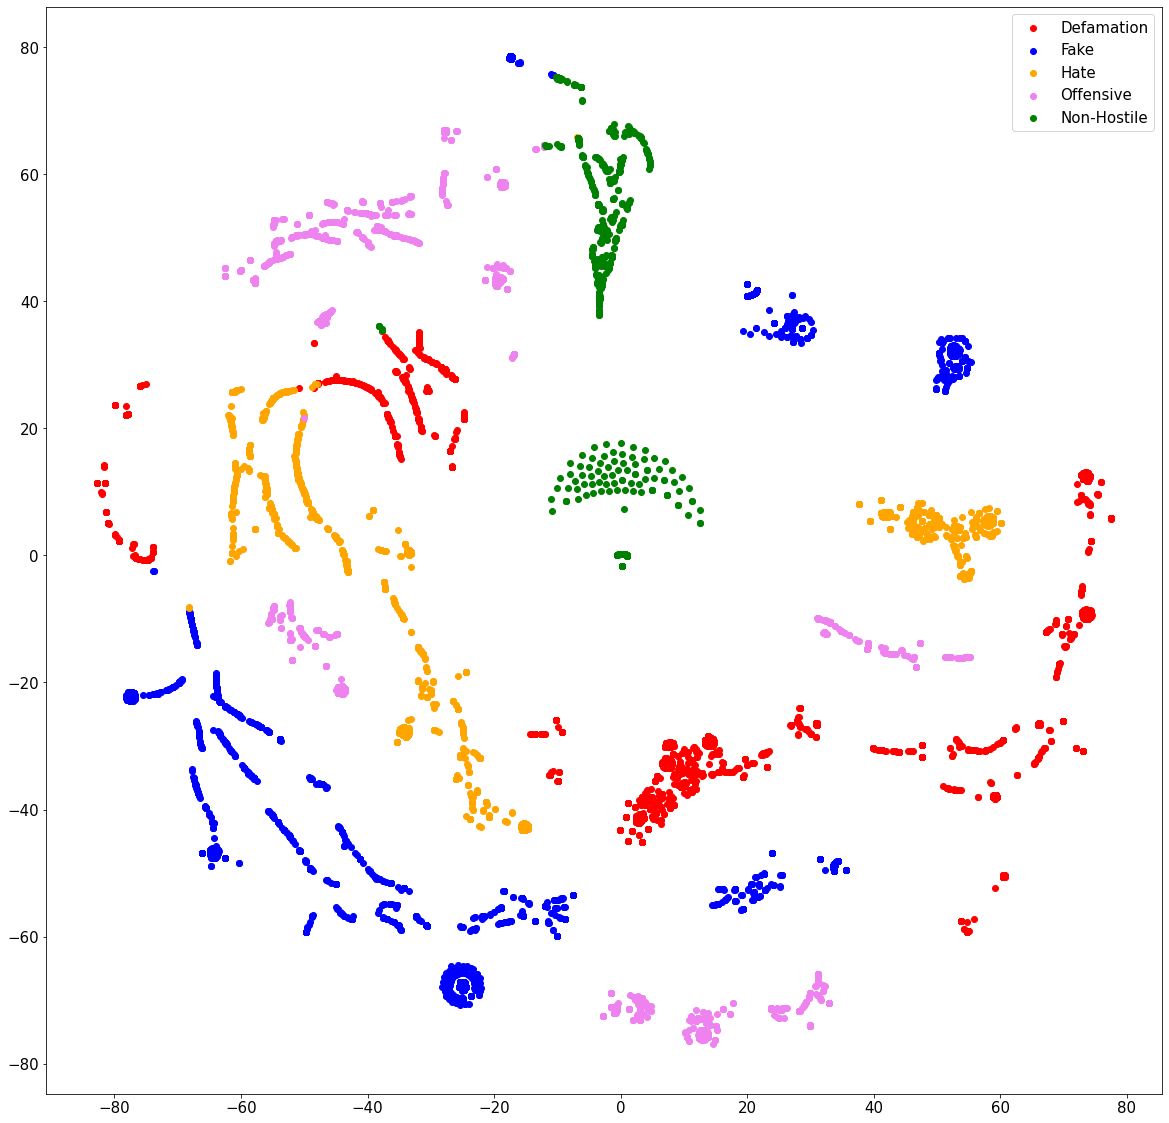



--------------Dumping Hostility Dict-------------


[641, 1304, 902, 845, 3485]


----------Creating  Hostility Dict Preprocessed without Emoji  Hostility Dict----------




----------Stats-----------


15282
[CLS] [0.0, 0.0, 0.0, 0.0, 0.0]
मेरे [0.478213942975029, 0.0017828147452921103, 0.5196783677416087, 0.00032487447454841413, 6.352168683020411e-11]
देश [0.00036773872221385073, 2.1589218629371756e-06, 0.9996023747272922, 2.7727566791676406e-05, 6.183944770811347e-11]
के [0.008816259768560503, 0.958831453083884, 0.030424952226697572, 0.0018862988110284393, 4.10361098297655e-05]
हिन्दु [1.2499884855072601e-15, 0.008957984097284892, 0.9910420143142354, 1.588478370839866e-09, 8.153361170313532e-18]


---------Mapping of a word to a dimension----------


Word महिला mapped to index :  Fake
Word भक्त mapped to index :  Defamation
Word देश mapped to index :  Hate
Word हिन्दु mapped to index :  Hate
Word मुसलमान mapped to index :  Hate


--------------TSNE Plot of  Sentence Piece Preproce

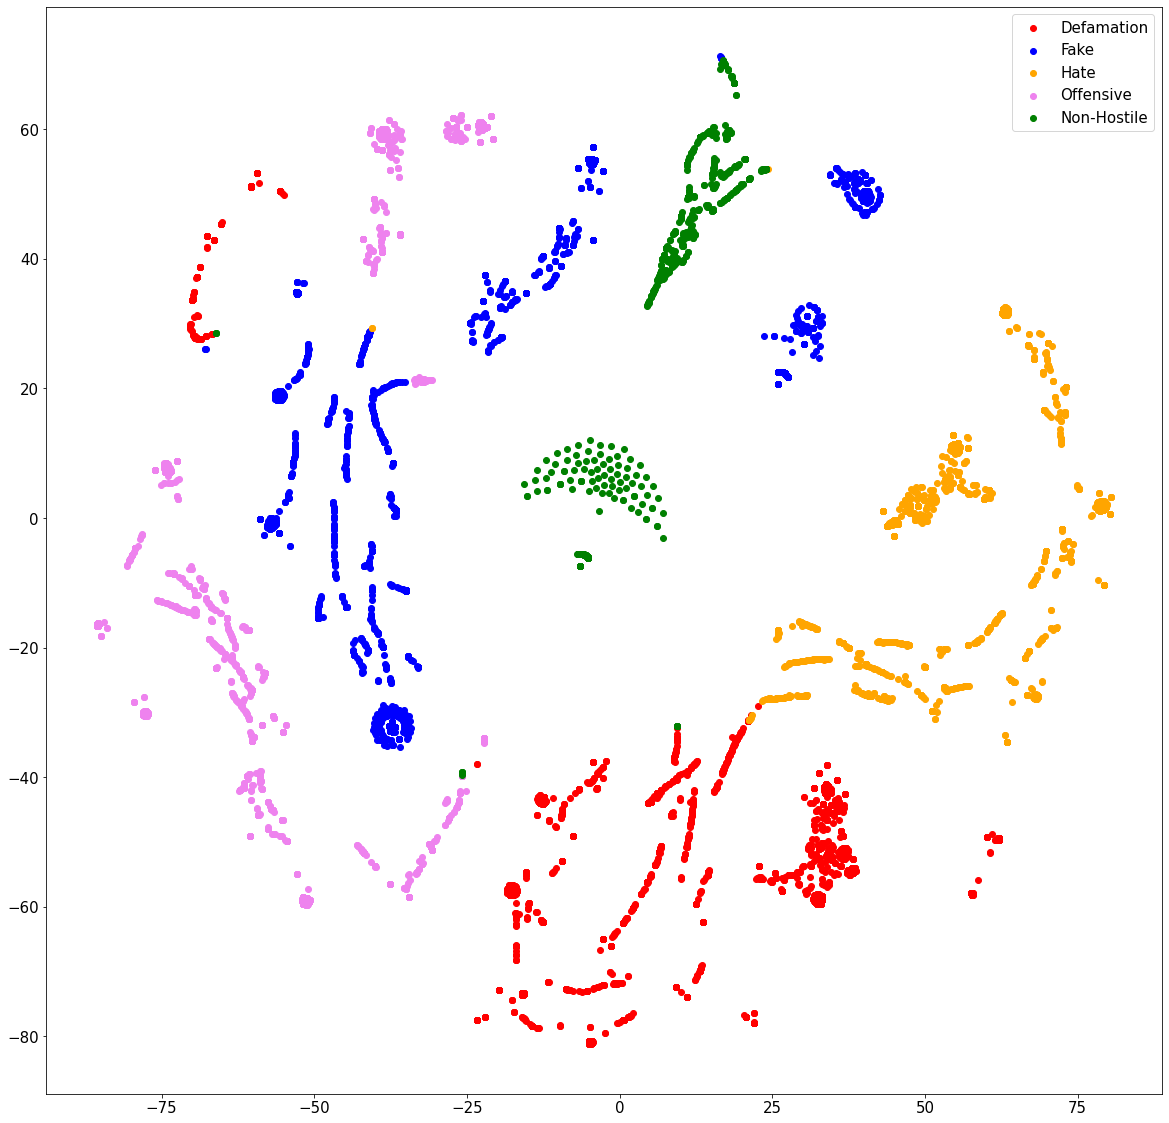



--------------Dumping Hostility Dict-------------


[641, 1304, 902, 845, 3485]


----------Creating  Hostility Dict Preprocessed with Emoji  Hostility Dict----------




----------Stats-----------


15346
[CLS] [0.0, 0.0, 0.0, 0.0, 0.0]
मेरे [0.478213942975029, 0.0017828147452921103, 0.5196783677416087, 0.00032487447454841413, 6.352168683020411e-11]
देश [0.00036773872221385073, 2.1589218629371756e-06, 0.9996023747272922, 2.7727566791676406e-05, 6.183944770811347e-11]
के [0.008901481098644984, 0.9584286360679105, 0.030724358060600736, 0.0019041230070523413, 4.14017657914858e-05]
हिन्दु [1.2499884855072601e-15, 0.008957984097284892, 0.9910420143142354, 1.588478370839866e-09, 8.153361170313532e-18]


---------Mapping of a word to a dimension----------


Word महिला mapped to index :  Fake
Word भक्त mapped to index :  Defamation
Word देश mapped to index :  Hate
Word हिन्दु mapped to index :  Hate
Word मुसलमान mapped to index :  Hate


--------------TSNE Plot of  Sentence Piece Preprocess

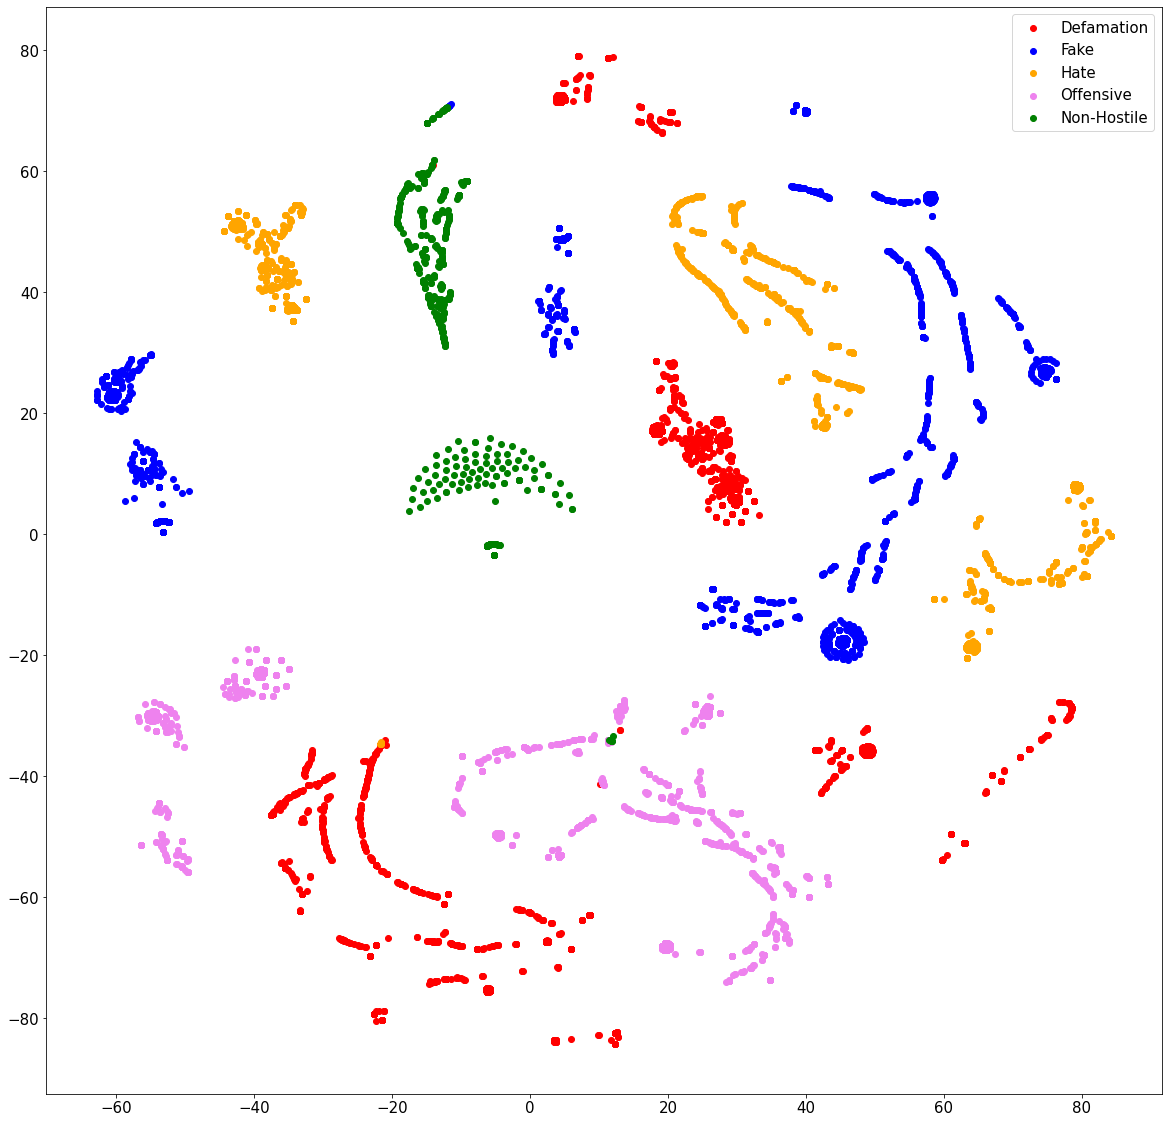



--------------Dumping Hostility Dict-------------




In [205]:
# for i in range(0,6):
#     create_softmax_hostility_dict(combined_df, i)

<h3> Adding Column Softmaxed Lexicon Vector, its Mask, and Average

In [16]:
train =  pickle.load(open("pkl_fine_train.pkl",'rb'))
valid =  pickle.load(open("pkl_fine_valid.pkl",'rb'))
test  =  pickle.load(open("pkl_fine_test.pkl",'rb'))

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 52)
(811, 52)
(1653, 52)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Sum Hashtag Vectors,Avg Hashtag Vectors,Sum Emoji Vectors,Avg Emoji Vectors,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.17825853824615479, 0.014308891259133816, 0....","[0.08912926912307739, 0.007154445629566908, 0....",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0,non-hostile


In [17]:
for i,column in enumerate(train.columns):
    print(i,column)

0 Unique ID
1 Post
2 Raw Text
3 Raw Text without Emoji
4 Raw Text with Emoji
5 Preprocessed
6 Preprocessed without Emoji
7 Preprocessed with Emoji
8 Sentence Piece Raw Text
9 Sentence Piece Raw Text without Emoji
10 Sentence Piece Raw Text with Emoji
11 Sentence Piece Preprocessed
12 Sentence Piece Preprocessed without Emoji
13 Sentence Piece Preprocessed with Emoji
14 Raw Text Lex Pad
15 Raw Text Lex Avg
16 Raw Text Mask
17 Raw Text DGA
18 Raw Text FGA
19 Raw Text HGA
20 Raw Text OGA
21 Raw Text without Emoji Lex Pad
22 Raw Text without Emoji Lex Avg
23 Raw Text without Emoji Mask
24 Raw Text without Emoji DGA
25 Raw Text without Emoji FGA
26 Raw Text without Emoji HGA
27 Raw Text without Emoji OGA
28 Raw Text with Emoji Lex Pad
29 Raw Text with Emoji Lex Avg
30 Raw Text with Emoji Mask
31 Raw Text with Emoji DGA
32 Raw Text with Emoji FGA
33 Raw Text with Emoji HGA
34 Raw Text with Emoji OGA
35 Preprocessed Lex Pad
36 Preprocessed Lex Avg
37 Preprocessed Mask
38 Preprocessed DGA
39 P

In [34]:
def add_lexicon(df,flag):

    lexicon_vectors         = []
    lexicon_vectors_average = []
    mask_vectors            = []
    pad_length              = 128
    
    org_col_name = ["Sentence Piece Raw Text", "Sentence Piece Raw Text without Emoji", "Sentence Piece Raw Text with Emoji",
                    "Sentence Piece Preprocessed", "Sentence Piece Preprocessed without Emoji", "Sentence Piece Preprocessed with Emoji"]
 
    new_col_name = ["Hostility Dict Raw Text", "Hostility Dict Raw Text without Emoji", "Hostility Dict Raw Text with Emoji",
                    "Hostility Dict Preprocessed", "Hostility Dict Preprocessed without Emoji", "Hostility Dict Preprocessed with Emoji"]
 

    column_index = [14,21,28,35,42,49]
    hostility_dict = pickle.load(open("SPT Data/21 March/"+new_col_name[flag]+".pkl", 'rb'))

    for idx in range(len(df)):


        lexicon_vector = []
        mask_vector    = []
        text           = df[org_col_name[flag]][idx]
        text           = text.split()[:pad_length]
        length         = len(text)

        for i in range(pad_length - len(text)):
            text.append("---") 

        average_lexicon = [0.,0.,0.,0.,0.]
        for word in text:
            if(hostility_dict.get(word)!=None):
                if(sum(hostility_dict[word])!=0):
#                     print("Accepted: ",word)
                    mask_vector.append(1)
                    lexicon_vector.append(hostility_dict[word])
                    average_lexicon = [i+j for i,j in zip(average_lexicon, hostility_dict[word])]
                else:
#                     print("Rejected: ",word)
                    lexicon_vector.append([0.]*5)
                    mask_vector.append(0)
                    
            else:
#                 print("Rejected: ",word)
                lexicon_vector.append([0.]*5)
                mask_vector.append(0)
                
        lexicon_vectors.append(np.asarray(lexicon_vector))
        mask_vectors.append(np.asarray(mask_vector))

        average_lexicon = [i/length for i in average_lexicon]
        lexicon_vectors_average.append(average_lexicon)
        
#     print(lexicon_vectors[0])
#     print(lexicon_vectors_average[0])
#     print(mask_vectors[0])



    df.insert(column_index[flag],  'Preprocessed with Emoji Lex Pad',   lexicon_vectors)
    df.insert(column_index[flag]+1,'Preprocessed with Emoji Lex Avg', lexicon_vectors_average)
    df.insert(column_index[flag]+2,'Preprocessed with Emoji Mask',    mask_vectors)



    return df

In [35]:
# a = copy.deepcopy(train)
# a = add_lexicon(a,0)
# a.head(2)

In [36]:
new_train = add_lexicon(train,5)
new_valid = add_lexicon(valid,5)
new_test = add_lexicon(test,5)

print(new_train.shape)
print(new_valid.shape)
print(new_test.shape)

train.head(2)

(5728, 62)
(811, 62)
(1653, 62)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Sum Hashtag Vectors,Avg Hashtag Vectors,Sum Emoji Vectors,Avg Emoji Vectors,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.17825853824615479, 0.014308891259133816, 0....","[0.08912926912307739, 0.007154445629566908, 0....",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0,non-hostile


In [37]:
for i,column in enumerate(train.columns):
    print(i,column)

0 Unique ID
1 Post
2 Raw Text
3 Raw Text without Emoji
4 Raw Text with Emoji
5 Preprocessed
6 Preprocessed without Emoji
7 Preprocessed with Emoji
8 Sentence Piece Raw Text
9 Sentence Piece Raw Text without Emoji
10 Sentence Piece Raw Text with Emoji
11 Sentence Piece Preprocessed
12 Sentence Piece Preprocessed without Emoji
13 Sentence Piece Preprocessed with Emoji
14 Raw Text Lex Pad
15 Raw Text Lex Avg
16 Raw Text Mask
17 Raw Text DGA
18 Raw Text FGA
19 Raw Text HGA
20 Raw Text OGA
21 Raw Text without Emoji Lex Pad
22 Raw Text without Emoji Lex Avg
23 Raw Text without Emoji Mask
24 Raw Text without Emoji DGA
25 Raw Text without Emoji FGA
26 Raw Text without Emoji HGA
27 Raw Text without Emoji OGA
28 Raw Text with Emoji Lex Pad
29 Raw Text with Emoji Lex Avg
30 Raw Text with Emoji Mask
31 Raw Text with Emoji DGA
32 Raw Text with Emoji FGA
33 Raw Text with Emoji HGA
34 Raw Text with Emoji OGA
35 Preprocessed Lex Pad
36 Preprocessed Lex Avg
37 Preprocessed Mask
38 Preprocessed DGA
39 P

In [289]:
pickle.dump(new_train,open("pkl_fine_train.pkl",'wb'))
pickle.dump(new_valid,open("pkl_fine_valid.pkl",'wb'))
pickle.dump(new_test,open("pkl_fine_test.pkl",'wb'))

In [290]:
train = pickle.load(open("pkl_fine_train.pkl",'rb'))
valid = pickle.load(open("pkl_fine_valid.pkl",'rb'))
test = pickle.load(open("pkl_fine_test.pkl",'rb'))
new_train.head(2)

,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Raw Text with Emoji OGA,Preprocessed Lex Pad,Preprocessed Lex Avg,Preprocessed Mask,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[tensor(0., dtype=torch.float64), tensor(0.022...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.478213942975029...","[0.15067189973935508, 0.24072557801822936, 0.1...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[tensor(0., dtype=torch.float64), tensor(0.021...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.046238528762721...","[0.11434287393589544, 0.33234260460320786, 0.1...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0,0,0,0,non-hostile


<h3> Plotting Sentence Lexicon Vectors

In [237]:
from sklearn.manifold import TSNE
def plot_sentence_tsne(df):

    df = df[df['Hostile']==1]
    df = df.reset_index(drop=True)
    tsne = TSNE(n_components=2, random_state=0)

    embeddings = []
    labels     = []
    
    label_to_id_dict = {'defamation':0, 'defamation,fake':1, 'defamation,fake,hate':2, 'defamation,fake,hate,offensive':3,
                        'defamation,fake,offensive':4, 'defamation,hate':5, 'defamation,hate,offensive':6,
                        'defamation,offensive':7, 'fake':8, 'fake,hate':9, 'fake,hate,offensive':10, 'fake,offensive':11,
                        'hate':12, 'hate,offensive':13, 'offensive':14}

    for i in range(len(df)):
        values = df['Raw Text Lex Pad'][i]
        
#         for j in values:
        embeddings.append(np.amax(values, axis=1))
                
        label = label_to_id_dict[df['Labels Set'][i]]
        labels.append(label)

    embeddings = np.asarray(embeddings)
    labels     = np.asarray(labels)

    cname_dict = {0:'defamation', 1:'defamation,fake', 2:'defamation,fake,hate', 3:'defamation,fake,hate,offensive',
                  4:'defamation,fake,offensive', 5:'defamation,hate', 6:'defamation,hate,offensive',
                  7:'defamation,offensive', 8:'fake', 9:'fake,hate', 10:'fake,hate,offensive', 11:'fake,offensive',
                  12:'hate', 13:'hate,offensive', 14:'offensive'}

    transformed = tsne.fit_transform(embeddings)
    fig, ax = plt.subplots(figsize=(10,10))
    for label in np.unique(labels): 
        indices = [i for i, l in enumerate(labels) if l == label]
        x = np.take(transformed[:,0], indices)
        y = np.take(transformed[:,1], indices)

#         cdict = {0: 'red', 1: 'blue', 2: 'orange', 3: 'green'}
        ax.scatter(x,y, label=cname_dict[label])
    
    ax.legend(loc='best')
    plt.show()

(5728, 23)


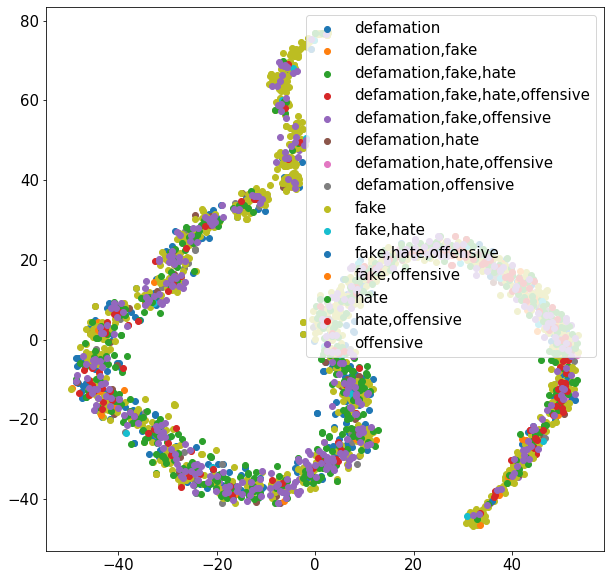

In [238]:
train = pickle.load(open("pkl_fine_train.pkl",'rb'))
# train = train.iloc[:50]
print(train.shape)

plot_sentence_tsne(train)

<h3> Creating Gold Attention Vectors

In [30]:
def masked_softmax(vec, mask, dim=0, epsilon=1e-5):
    exps = torch.exp(vec)
    masked_exps = exps * mask
    masked_sums = masked_exps.sum(dim, keepdim=True) + epsilon
    return (masked_exps/masked_sums)

In [240]:
a = torch.tensor([1., 0. ,3.])
mask = torch.tensor([1,0,1])
print(masked_softmax(a,mask))

tensor([0.1192, 0.0000, 0.8808])


In [291]:
train = pickle.load(open("pkl_fine_train.pkl",'rb'))
valid = pickle.load(open("pkl_fine_valid.pkl",'rb'))
test  = pickle.load(open("pkl_fine_test.pkl",'rb'))

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 44)
(811, 44)
(1653, 44)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Raw Text with Emoji OGA,Preprocessed Lex Pad,Preprocessed Lex Avg,Preprocessed Mask,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[tensor(0., dtype=torch.float64), tensor(0.022...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.478213942975029...","[0.15067189973935508, 0.24072557801822936, 0.1...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[tensor(0., dtype=torch.float64), tensor(0.021...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.046238528762721...","[0.11434287393589544, 0.33234260460320786, 0.1...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0,0,0,0,non-hostile


In [261]:
train['Raw Text without Emoji Mask'][0]

array([0, 1, 1, 1, ..., 0, 0, 0, 0])

In [262]:
train['Sentence Piece Raw Text without Emoji'][0]

'[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है जय श्री राम [SEP]'

In [38]:
def create_gold_attention_vectors(df):
    
    all_def_gold_attn  = []
    all_fake_gold_attn = []
    all_hate_gold_attn = []
    all_off_gold_attn  = []
    
    
    for i in range(len(df)):
        def_gold_attn  = []
        fake_gold_attn = []
        hate_gold_attn = []
        off_gold_attn  = []
        
        values = df['Preprocessed with Emoji Lex Pad'][i]
        mask   = df['Preprocessed with Emoji Mask'][i]
        
        for j in values:
            def_gold_attn.append(j[0])
            fake_gold_attn.append(j[1])
            hate_gold_attn.append(j[2])
            off_gold_attn.append(j[3])  
            
            
        def_gold_attn  = masked_softmax(torch.tensor(def_gold_attn), torch.tensor(mask))
        fake_gold_attn = masked_softmax(torch.tensor(fake_gold_attn), torch.tensor(mask))
        hate_gold_attn = masked_softmax(torch.tensor(hate_gold_attn), torch.tensor(mask))
        off_gold_attn  = masked_softmax(torch.tensor(off_gold_attn), torch.tensor(mask))
 
        
        all_def_gold_attn.append(def_gold_attn)
        all_fake_gold_attn.append(fake_gold_attn)
        all_hate_gold_attn.append(hate_gold_attn)
        all_off_gold_attn.append(off_gold_attn)

        
    
    df.insert(52,'Preprocessed with Emoji DGA',  all_def_gold_attn)
    df.insert(53,'Preprocessed with Emoji FGA',  all_fake_gold_attn)
    df.insert(54,'Preprocessed with Emoji HGA',  all_hate_gold_attn)
    df.insert(55,'Preprocessed with Emoji OGA',  all_off_gold_attn)
                                     
    return df

In [39]:
train = create_gold_attention_vectors(train)
valid = create_gold_attention_vectors(valid)
test  = create_gold_attention_vectors(test)

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 66)
(811, 66)
(1653, 66)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Sum Hashtag Vectors,Avg Hashtag Vectors,Sum Emoji Vectors,Avg Emoji Vectors,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.17825853824615479, 0.014308891259133816, 0....","[0.08912926912307739, 0.007154445629566908, 0....",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0,non-hostile


In [40]:
for i,column in enumerate(train.columns):
    print(i,column)

0 Unique ID
1 Post
2 Raw Text
3 Raw Text without Emoji
4 Raw Text with Emoji
5 Preprocessed
6 Preprocessed without Emoji
7 Preprocessed with Emoji
8 Sentence Piece Raw Text
9 Sentence Piece Raw Text without Emoji
10 Sentence Piece Raw Text with Emoji
11 Sentence Piece Preprocessed
12 Sentence Piece Preprocessed without Emoji
13 Sentence Piece Preprocessed with Emoji
14 Raw Text Lex Pad
15 Raw Text Lex Avg
16 Raw Text Mask
17 Raw Text DGA
18 Raw Text FGA
19 Raw Text HGA
20 Raw Text OGA
21 Raw Text without Emoji Lex Pad
22 Raw Text without Emoji Lex Avg
23 Raw Text without Emoji Mask
24 Raw Text without Emoji DGA
25 Raw Text without Emoji FGA
26 Raw Text without Emoji HGA
27 Raw Text without Emoji OGA
28 Raw Text with Emoji Lex Pad
29 Raw Text with Emoji Lex Avg
30 Raw Text with Emoji Mask
31 Raw Text with Emoji DGA
32 Raw Text with Emoji FGA
33 Raw Text with Emoji HGA
34 Raw Text with Emoji OGA
35 Preprocessed Lex Pad
36 Preprocessed Lex Avg
37 Preprocessed Mask
38 Preprocessed DGA
39 P

In [41]:
print(sum(train['Raw Text DGA'][0]))


print(len(train['Sentence Piece Raw Text'][0].split()))


print(sum(train['Raw Text Mask'][0]))


print("\n\n",train['Sentence Piece Raw Text'][0])


print(train['Raw Text Mask'][0])

for i,j in zip(train['Sentence Piece Raw Text'][0].split(),train['Raw Text Mask'][0]):
    print(i," --> ", j)


tensor(1.0000, dtype=torch.float64)
28
26


 [CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏 [SEP]
[0 1 1 1 ... 0 0 0 0]
[CLS]  -->  0
मेरे  -->  1
देश  -->  1
के  -->  1
हिन्दु  -->  1
बहुत  -->  1
निरा  -->  1
##ले  -->  1
है  -->  1
।  -->  1
कुछ  -->  1
तो  -->  1
पक्के  -->  1
राम  -->  1
भक्त  -->  1
है  -->  1
और  -->  1
कुछ  -->  1
बाबर  -->  1
के  -->  1
साले  -->  1
है  -->  1
🙏  -->  1
जय  -->  1
श्री  -->  1
राम  -->  1
🙏  -->  1
[SEP]  -->  0


In [42]:
pickle.dump(train, open("pkl_fine_train.pkl",'wb'))
pickle.dump(valid, open("pkl_fine_valid.pkl",'wb'))
pickle.dump(test, open("pkl_fine_test.pkl",'wb'))

In [43]:
train = pickle.load(open("pkl_fine_train.pkl",'rb'))
valid = pickle.load( open("pkl_fine_valid.pkl",'rb'))
test  = pickle.load( open("pkl_fine_test.pkl",'rb'))

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 66)
(811, 66)
(1653, 66)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Sum Hashtag Vectors,Avg Hashtag Vectors,Sum Emoji Vectors,Avg Emoji Vectors,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.17825853824615479, 0.014308891259133816, 0....","[0.08912926912307739, 0.007154445629566908, 0....",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0,non-hostile


In [44]:
train['Raw Text DGA'][0]

tensor([0.0000, 0.0449, 0.0278, 0.0282, 0.0278, 0.0598, 0.0278, 0.0278, 0.0336,
        0.0278, 0.0296, 0.0326, 0.0278, 0.0330, 0.0756, 0.0336, 0.0279, 0.0296,
        0.0756, 0.0282, 0.0278, 0.0336, 0.0756, 0.0278, 0.0278, 0.0330, 0.0756,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [45]:
for i,column in enumerate(train.columns):
    print(i,column)

0 Unique ID
1 Post
2 Raw Text
3 Raw Text without Emoji
4 Raw Text with Emoji
5 Preprocessed
6 Preprocessed without Emoji
7 Preprocessed with Emoji
8 Sentence Piece Raw Text
9 Sentence Piece Raw Text without Emoji
10 Sentence Piece Raw Text with Emoji
11 Sentence Piece Preprocessed
12 Sentence Piece Preprocessed without Emoji
13 Sentence Piece Preprocessed with Emoji
14 Raw Text Lex Pad
15 Raw Text Lex Avg
16 Raw Text Mask
17 Raw Text DGA
18 Raw Text FGA
19 Raw Text HGA
20 Raw Text OGA
21 Raw Text without Emoji Lex Pad
22 Raw Text without Emoji Lex Avg
23 Raw Text without Emoji Mask
24 Raw Text without Emoji DGA
25 Raw Text without Emoji FGA
26 Raw Text without Emoji HGA
27 Raw Text without Emoji OGA
28 Raw Text with Emoji Lex Pad
29 Raw Text with Emoji Lex Avg
30 Raw Text with Emoji Mask
31 Raw Text with Emoji DGA
32 Raw Text with Emoji FGA
33 Raw Text with Emoji HGA
34 Raw Text with Emoji OGA
35 Preprocessed Lex Pad
36 Preprocessed Lex Avg
37 Preprocessed Mask
38 Preprocessed DGA
39 P

<h2> Encoding Hashtags

In [305]:
train =  pickle.load(open("pkl_fine_train.pkl",'rb'))
valid =  pickle.load(open("pkl_fine_valid.pkl",'rb'))
test  =  pickle.load(open("pkl_fine_test.pkl",'rb'))

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 48)
(811, 48)
(1653, 48)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Preprocessed DGA,Preprocessed FGA,Preprocessed HGA,Preprocessed OGA,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[tensor(0., dtype=torch.float64), tensor(0.067...","[tensor(0., dtype=torch.float64), tensor(0.036...","[tensor(0., dtype=torch.float64), tensor(0.066...","[tensor(0., dtype=torch.float64), tensor(0.034...",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[tensor(0., dtype=torch.float64), tensor(0.053...","[tensor(0., dtype=torch.float64), tensor(0.051...","[tensor(0., dtype=torch.float64), tensor(0.103...","[tensor(0., dtype=torch.float64), tensor(0.052...",0,0,0,0,0,non-hostile


In [306]:
for i,column in enumerate(train.columns):
    print(i,column)

0 Unique ID
1 Post
2 Raw Text
3 Raw Text without Emoji
4 Raw Text with Emoji
5 Preprocessed
6 Preprocessed without Emoji
7 Preprocessed with Emoji
8 Sentence Piece Raw Text
9 Sentence Piece Raw Text without Emoji
10 Sentence Piece Raw Text with Emoji
11 Sentence Piece Preprocessed
12 Sentence Piece Preprocessed without Emoji
13 Sentence Piece Preprocessed with Emoji
14 Raw Text Lex Pad
15 Raw Text Lex Avg
16 Raw Text Mask
17 Raw Text DGA
18 Raw Text FGA
19 Raw Text HGA
20 Raw Text OGA
21 Raw Text without Emoji Lex Pad
22 Raw Text without Emoji Lex Avg
23 Raw Text without Emoji Mask
24 Raw Text without Emoji DGA
25 Raw Text without Emoji FGA
26 Raw Text without Emoji HGA
27 Raw Text without Emoji OGA
28 Raw Text with Emoji Lex Pad
29 Raw Text with Emoji Lex Avg
30 Raw Text with Emoji Mask
31 Raw Text with Emoji DGA
32 Raw Text with Emoji FGA
33 Raw Text with Emoji HGA
34 Raw Text with Emoji OGA
35 Preprocessed Lex Pad
36 Preprocessed Lex Avg
37 Preprocessed Mask
38 Preprocessed DGA
39 P

In [307]:
def add_hashtag_vec(df):
    
    avg_hashtag_vectors = []
    sum_hashtag_vectors = []
    
    for i in range(len(df)):
        text = df['Post'][i]
        text = ' '.join([seg_tw.segment(word[1:]) if word[0] == '#' else "" for word in text.split()])
        
        text = text.split()
#         print(text)
        if(len(text)==0):
            
            avg_hashtag_vector = ft_model['#']
            sum_hashtag_vector = ft_model['#']
         
        else:
            avg_hashtag_vector = np.zeros(300)
            sum_hashtag_vector = np.zeros(300)


            for hashtag in text:
                sum_hashtag_vector += ft_model[hashtag]

            avg_hashtag_vector = sum_hashtag_vector/ len(text)

        sum_hashtag_vectors.append(sum_hashtag_vector)
        avg_hashtag_vectors.append(avg_hashtag_vector)

    df.insert(df.shape[1]-6, "Sum Hashtag Vectors", sum_hashtag_vectors)
    df.insert(df.shape[1]-6, "Avg Hashtag Vectors", avg_hashtag_vectors)
    return df
        
        

In [308]:
train = add_hashtag_vec(train)
valid = add_hashtag_vec(valid)
test = add_hashtag_vec(test)

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 50)
(811, 50)
(1653, 50)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Preprocessed HGA,Preprocessed OGA,Sum Hashtag Vectors,Avg Hashtag Vectors,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[tensor(0., dtype=torch.float64), tensor(0.066...","[tensor(0., dtype=torch.float64), tensor(0.034...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[tensor(0., dtype=torch.float64), tensor(0.103...","[tensor(0., dtype=torch.float64), tensor(0.052...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...",0,0,0,0,0,non-hostile


In [309]:
pickle.dump(train,open("pkl_fine_train.pkl",'wb'))
pickle.dump(valid,open("pkl_fine_valid.pkl",'wb'))
pickle.dump(test,open("pkl_fine_test.pkl",'wb'))

In [310]:
train = pickle.load(open("pkl_fine_train.pkl",'rb'))
valid = pickle.load(open("pkl_fine_valid.pkl",'rb'))
test = pickle.load(open("pkl_fine_test.pkl",'rb'))

In [311]:
train.head(2)

,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Preprocessed HGA,Preprocessed OGA,Sum Hashtag Vectors,Avg Hashtag Vectors,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[tensor(0., dtype=torch.float64), tensor(0.066...","[tensor(0., dtype=torch.float64), tensor(0.034...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[tensor(0., dtype=torch.float64), tensor(0.103...","[tensor(0., dtype=torch.float64), tensor(0.052...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...",0,0,0,0,0,non-hostile


In [312]:
train['Sum Hashtag Vectors'][6]

array([ 0.849927,  0.204594,  0.605047,  1.119605, ..., -3.228608, -1.034811,  0.096484,  0.140171])

<h2> Adding Emoji Vectors

In [308]:
!git clone https://github.com/uclnlp/emoji2vec  #for emoji2vec file

Cloning into 'emoji2vec'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 62 (delta 0), reused 1 (delta 0), pack-reused 59
Unpacking objects: 100% (62/62), done.


In [314]:
e2v = gsm.KeyedVectors.load_word2vec_format("emoji2vec/pre-trained/emoji2vec.bin", binary=True)
happy_vector = e2v['🙏']
happy_vector.shape

(300,)

In [315]:
def add_emoji_vec(df):
    avg_emoji_vectors = []
    sum_emoji_vectors = []

    
    for i in range(len(df)):
        text = df['Post'][i]
        text = ''.join(emo for emo in text if emo in UNICODE_EMO)
        avg_emoji_vector = np.zeros(300)
        sum_emoji_vector = np.zeros(300)
        
        if(len(text)!=0):
            for emoji in text:
                try:
                    sum_emoji_vector += e2v[emoji]
                except:
                    sum_emoji_vector += np.zeros(300)
            avg_emoji_vector = sum_emoji_vector/len(text)
            
        avg_emoji_vectors.append(avg_emoji_vector)
        sum_emoji_vectors.append(sum_emoji_vector)        
        
    df.insert(df.shape[1]-6, "Sum Emoji Vectors", sum_emoji_vectors)
    df.insert(df.shape[1]-6, "Avg Emoji Vectors", avg_emoji_vectors)
    return df

In [316]:
train = add_emoji_vec(train)
valid = add_emoji_vec(valid)
test = add_emoji_vec(test)

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 52)
(811, 52)
(1653, 52)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Sum Hashtag Vectors,Avg Hashtag Vectors,Sum Emoji Vectors,Avg Emoji Vectors,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.17825853824615479, 0.014308891259133816, 0....","[0.08912926912307739, 0.007154445629566908, 0....",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0,non-hostile


In [317]:
for i,column in enumerate(train.columns):
    print(i,column)

0 Unique ID
1 Post
2 Raw Text
3 Raw Text without Emoji
4 Raw Text with Emoji
5 Preprocessed
6 Preprocessed without Emoji
7 Preprocessed with Emoji
8 Sentence Piece Raw Text
9 Sentence Piece Raw Text without Emoji
10 Sentence Piece Raw Text with Emoji
11 Sentence Piece Preprocessed
12 Sentence Piece Preprocessed without Emoji
13 Sentence Piece Preprocessed with Emoji
14 Raw Text Lex Pad
15 Raw Text Lex Avg
16 Raw Text Mask
17 Raw Text DGA
18 Raw Text FGA
19 Raw Text HGA
20 Raw Text OGA
21 Raw Text without Emoji Lex Pad
22 Raw Text without Emoji Lex Avg
23 Raw Text without Emoji Mask
24 Raw Text without Emoji DGA
25 Raw Text without Emoji FGA
26 Raw Text without Emoji HGA
27 Raw Text without Emoji OGA
28 Raw Text with Emoji Lex Pad
29 Raw Text with Emoji Lex Avg
30 Raw Text with Emoji Mask
31 Raw Text with Emoji DGA
32 Raw Text with Emoji FGA
33 Raw Text with Emoji HGA
34 Raw Text with Emoji OGA
35 Preprocessed Lex Pad
36 Preprocessed Lex Avg
37 Preprocessed Mask
38 Preprocessed DGA
39 P

In [318]:
# pickle.dump(train,open("pkl_fine_train.pkl",'wb'))
# pickle.dump(valid,open("pkl_fine_valid.pkl",'wb'))
# pickle.dump(test,open("pkl_fine_test.pkl",'wb'))

In [320]:
train = pickle.load(open("pkl_fine_train.pkl",'rb'))
valid = pickle.load(open("pkl_fine_valid.pkl",'rb'))
test = pickle.load(open("pkl_fine_test.pkl",'rb'))

print(train.shape)
print(valid.shape)
print(test.shape)

train.head(2)

(5728, 52)
(811, 52)
(1653, 52)


,Unique ID,Post,Raw Text,Raw Text without Emoji,Raw Text with Emoji,Preprocessed,Preprocessed without Emoji,Preprocessed with Emoji,Sentence Piece Raw Text,Sentence Piece Raw Text without Emoji,...,Sum Hashtag Vectors,Avg Hashtag Vectors,Sum Emoji Vectors,Avg Emoji Vectors,Hostile,Defamation,Fake,Hate,Offensive,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,मेरे देश के हिन्दु निराले है। पक्के राम भक्...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,[CLS] मेरे देश के हिन्दु बहुत निरा ##ले है । क...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.17825853824615479, 0.014308891259133816, 0....","[0.08912926912307739, 0.007154445629566908, 0....",1,0,0,1,1,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,सरकार हमेशा किसानों कमाई बढ़ाने के नईनई स्...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,[CLS] सरकार हमेशा से किसानों की कमाई को बढ़ाने...,...,"[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.28952006, -0.5797294, 0.06613763, -0.166677...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0,non-hostile


In [321]:
for i,column in enumerate(train.columns):
    print(i,column)

0 Unique ID
1 Post
2 Raw Text
3 Raw Text without Emoji
4 Raw Text with Emoji
5 Preprocessed
6 Preprocessed without Emoji
7 Preprocessed with Emoji
8 Sentence Piece Raw Text
9 Sentence Piece Raw Text without Emoji
10 Sentence Piece Raw Text with Emoji
11 Sentence Piece Preprocessed
12 Sentence Piece Preprocessed without Emoji
13 Sentence Piece Preprocessed with Emoji
14 Raw Text Lex Pad
15 Raw Text Lex Avg
16 Raw Text Mask
17 Raw Text DGA
18 Raw Text FGA
19 Raw Text HGA
20 Raw Text OGA
21 Raw Text without Emoji Lex Pad
22 Raw Text without Emoji Lex Avg
23 Raw Text without Emoji Mask
24 Raw Text without Emoji DGA
25 Raw Text without Emoji FGA
26 Raw Text without Emoji HGA
27 Raw Text without Emoji OGA
28 Raw Text with Emoji Lex Pad
29 Raw Text with Emoji Lex Avg
30 Raw Text with Emoji Mask
31 Raw Text with Emoji DGA
32 Raw Text with Emoji FGA
33 Raw Text with Emoji HGA
34 Raw Text with Emoji OGA
35 Preprocessed Lex Pad
36 Preprocessed Lex Avg
37 Preprocessed Mask
38 Preprocessed DGA
39 P